In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import torch                 
import wandb  
import tempfile
import string
import math

from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from scipy import stats
import eq 

project_root_path = Path(eq.__file__).parents[1]

# SCEDC Earthquake forecasts
We compare extended earthquake forecasts with the Southern California earthquake catalog following the standard training procedure. These extended forecasts are generated by simulating a set of catalog continuations during the testing period.

## Download the results
The results of the 14-day forecast should be stored in the folder `results/samples_SCEDC_t14_n50000/`.

In [2]:
results_dir = project_root_path / "results" / "samples_SCEDC_t14_n50000"

While loading in results we also compute useful metrics including the modal, median, and 95% percent confidence interval (quantiles) for the number of events in each forecast.

In [3]:
results_ntpp = []
results_etas = []
for file in tqdm(list(results_dir.iterdir())):
    data = np.load(file, allow_pickle=True).tolist()
    data['N_mode'] = stats.mode(data["n_sampled"])[0][0]
    
    data['N_025'] = np.quantile(data["n_sampled"],0.025)
    data['N_50']  = np.quantile(data["n_sampled"],0.5)
    data['N_975'] = np.quantile(data["n_sampled"],0.975)
    
    del data["n_sampled"]
    if data["model_name"] == "RecurrentTPP":
        results_ntpp.append(data)
    else:
        results_etas.append(data)
        
df_ntpp = pd.DataFrame(results_ntpp)
df_etas = pd.DataFrame(results_etas)
df_ntpp.sort_values(by="time_index", inplace=True, ignore_index=True)
df_etas.sort_values(by="time_index", inplace=True, ignore_index=True)

  0%|          | 0/310 [00:00<?, ?it/s]

## Results

### NTPP Forecasts

In [4]:
df_ntpp.head()

,time_index,t_start,forecast_length,n_obs,quantile,likelihood,model_name,dataset_name,N_mode,N_025,N_50,N_975
0,1,12067.0,14,47,0.66988,0.02312,RecurrentTPP,SCEDC,38,22.0,40.0,130.000
1,2,12081.0,14,44,0.49722,0.03210,RecurrentTPP,SCEDC,42,24.0,44.0,123.000
2,3,12095.0,14,33,0.18700,0.02962,RecurrentTPP,SCEDC,37,23.0,42.0,134.000
3,4,12109.0,14,51,0.82462,0.01432,RecurrentTPP,SCEDC,34,20.0,38.0,101.000
4,5,12123.0,14,49,0.24876,0.02514,RecurrentTPP,SCEDC,52,35.0,58.0,193.025


### ETAS Forecasts

In [5]:
df_etas.head()

,time_index,t_start,forecast_length,n_obs,quantile,likelihood,model_name,dataset_name,N_mode,N_025,N_50,N_975
0,1,12067.0,14,47,0.07148,0.00748,ETAS,SCEDC,76,37.0,86.0,224.000
1,2,12081.0,14,44,0.04442,0.00568,ETAS,SCEDC,76,39.0,89.0,225.000
2,3,12095.0,14,33,0.00550,0.00142,ETAS,SCEDC,81,41.0,93.0,235.000
3,4,12109.0,14,51,0.12172,0.00864,ETAS,SCEDC,71,36.0,84.0,217.025
4,5,12123.0,14,49,0.08006,0.00756,ETAS,SCEDC,65,38.0,89.0,224.000


### Rate of surprises

We define susprizes as the number of intervals for which the observed number of events at the end of the forecast interval are outside the 95% confidence interval of the set of catalog continuations.

In [6]:
d_surprize = {
    'NTPP': ((df_ntpp["quantile"] < 0.025) + (df_ntpp["quantile"] > 0.975)).sum(),
    'ETAS': ((df_etas["quantile"] < 0.025) + (df_etas["quantile"] > 0.975)).sum(),
}

tot = len(df_etas)
[print(f"{v} of {tot} ({v/tot*100:0.1f}%) intervals were outside the 95 percitle confidence interval for the {k} model") for k,v in d_surprize.items()];


21 of 155 (13.5%) intervals were outside the 95 percitle confidence interval for the NTPP model
51 of 155 (32.9%) intervals were outside the 95 percitle confidence interval for the ETAS model


In [7]:
# Conbine results
all_results = pd.merge(df_ntpp, df_etas, on="t_start", suffixes=["_ntpp", "_etas"])[["t_start", "likelihood_ntpp", "likelihood_etas"]]
all_results.sort_values(by="t_start", inplace=True)
all_results.reset_index(inplace=True, drop=True)

We evaluate the acuracy of the forecast by computing the approximate model log-likelihood for the number of events in the forecast interval given the simulated trajectories:
$$ \log \hat{\mathcal{L}} = \sum^{N_{tot}}_{k=1} I(n_k = n_{obs})/N_{tot}$$
where where $I(x)$ is the indicator function that is 1 where $x$ is true and 0 otherwise, $n_k$ is the number of events in the $k$ th simulation, $n_{obs}$ is the number of events observed during the forecasting interval and  $N_{tot}$ is the total number of simulations which we set to 50,000. 

Note that $\log \hat{\mathcal{L}}$ is not defined for complete misses, that is, if no simulated catalog continuation had the same number of events than the observation. We treat these cases seperately.

In [8]:
ll_ntpp = np.log(all_results.likelihood_ntpp).values
ll_etas = np.log(all_results.likelihood_etas).values
llr = ll_ntpp - ll_etas
llr = llr[np.isfinite(llr)]

/nfs/staff-ssd/shchur/miniconda3/envs/eq/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2832509/1817975762.py:3: RuntimeWarning: invalid value encountered in subtract
  llr = ll_ntpp - ll_etas


In [9]:
print(f"Mean LLR: {np.mean(llr):.3f}")
print(f"Fraction of intervals where NTPP > ETAS: {np.sum(llr>0) + np.isinf(ll_etas).sum() - np.isinf(ll_ntpp).sum()} of {tot} intervals ({np.mean(llr > 0) * 100:.2f}%)")
print(f"# of intervals where NTPP got 0 likelihood: {np.isinf(ll_ntpp).sum()}")
print(f"# of intervals where ETAS got 0 likelihood: {np.isinf(ll_etas).sum()}")

Mean LLR: 1.086
Fraction of intervals where NTPP > ETAS: 138 of 155 intervals (88.97%)
# of intervals where NTPP got 0 likelihood: 1
# of intervals where ETAS got 0 likelihood: 10


## Load trained models

In [10]:
dataset_name = "SCEDC"
catalog = getattr(eq.catalogs, dataset_name)()

Loading existing catalog from /nfs/homedirs/shchur/research/earthquake-ntpp-release/data/SCEDC.


/nfs/homedirs/shchur/research/earthquake-ntpp-release/eq/data/sequence.py:153: UserWarning: Found 2 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


In [11]:
ntpp_model = eq.models.RecurrentTPP.load_from_checkpoint(project_root_path / "trained_models" / "SCEDC_RecurrentTPP.ckpt")
etas_model = eq.models.ETAS.load_from_checkpoint(project_root_path / "trained_models" / "SCEDC_ETAS.ckpt")
ntpp_model.eval()
etas_model.eval()


ETAS()

Note that in this implementation we do not generate a forecast for the magnitude distribution. Both models sample a a truncated Gutenberg Richter distribution using a b-value fit to the training set.

In [12]:
# Set MLE of the b parameter
mag_mean = torch.cat([seq.mag for seq in catalog.train]).mean().item()
precision = {
    "SCEDC": 0.1,
    "QTMSanJacinto": 0.01,
    "QTMSaltonSea": 0.01,
}
richter_b_mle = (
    math.log10(math.exp(1)) / (mag_mean - catalog.metadata["mag_completeness"] + 0.5 * precision[dataset_name])
)
ntpp_model.richter_b.data.fill_(richter_b_mle)
etas_model.b.data.data.fill_(richter_b_mle);

## Generate figure

In [13]:
def generate_forecast(model, seq, t_start, duration, num_samples):
    """
    Args:
        model: Model to sample from
        seq: Full event sequence
        t_start: Starting time of the forecast
        duration: Duration of the forecast
        num_samples: Number of trajectories to sample
    """
    s_cond = seq.get_subsequence(seq.t_start, t_start)
    samples = model.sample(num_samples, duration, past_seq=s_cond, return_sequences=True)
    return samples

In [14]:
def day2timestamp(N,start_time_stamp=catalog.metadata["start_ts"]):
    return start_time_stamp + N * pd.Timedelta(1,'D')

def plot_earthquakes(
    seq, 
    ax=None, 
    color="darkslategrey", 
    alpha=0.4, 
):
    if ax is None:
        ax = plt.gca()
    t =seq.arrival_times.numpy()
    t = day2timestamp(t)
    mag = seq.mag.numpy()
    ax.scatter(t, mag, s=np.exp(mag/2), c=color, alpha=alpha, edgecolors='none')
    
def plot_counting_process(
    seq, 
    ax=None, 
    color="k", 
    alpha=1.0, 
    T0=None,
    T=None,
):
    if ax is None:
        ax = plt.gca()
            
    t = np.append(seq.arrival_times.numpy(),T)
    t = np.insert(t, 0, T0, axis=0)
    
    t = day2timestamp(t)
    
    N = np.arange(len(t)-1)
    N = np.append(N,N[-1])
    ax.plot(t, N, c=color, alpha=alpha)

In [15]:
t_start  = 13100-3*14-4
duration = 14
seq = catalog.test[0].get_subsequence(10000, catalog.test[0].t_end)

In [16]:
ntpp_samples = generate_forecast(ntpp_model, seq, t_start, duration, num_samples=10000)

/tmp/ipykernel_2832509/1625349122.py:81: RuntimeWarning: invalid value encountered in subtract
  axCC.plot(day2timestamp(all_results.t_start),ll_ntpp-ll_etas,c='C1',alpha=0.5,lw=1)
/tmp/ipykernel_2832509/1625349122.py:88: RuntimeWarning: invalid value encountered in subtract
  def plot_misses(t=all_results.t_start,lr=ll_ntpp-ll_etas,fun=np.isneginf, val=axCC.get_ylim()[0], ax=axCC):


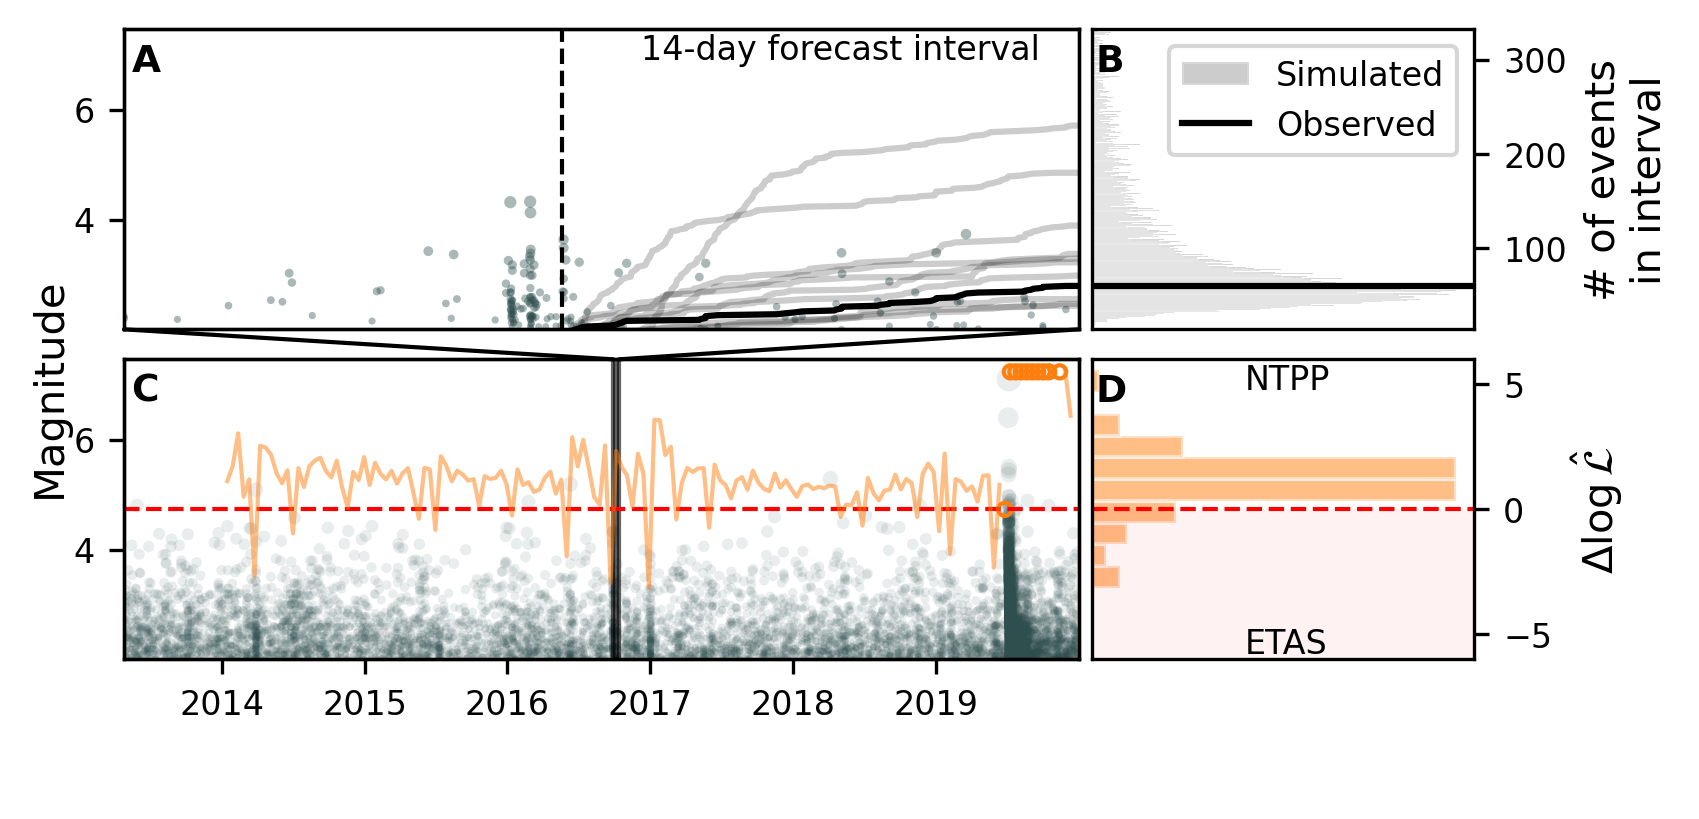

In [17]:
# Plot supplementart figures 
font = {'size'   : 8}
mpl.rc('font',**font)
fig = plt.figure(figsize=(6, 3), dpi=300)
gs = fig.add_gridspec(
    2, 2,  
    width_ratios=(3, 1.2), 
    height_ratios=(1,1),
    left=0.1, 
    right=0.85, 
    bottom=0.2, 
    top=0.9,
    wspace=0.02, 
    hspace=0.1
)
mpl.rcParams['axes.labelsize'] = 10 

axA = fig.add_subplot(gs[0,0])
axAA= axA.twinx()
axB = fig.add_subplot(gs[0,1],sharey=axAA)

axC = fig.add_subplot(gs[1,0],sharey=axA)
axCC= axC.twinx()
axD = fig.add_subplot(gs[1,1],sharey=axCC)

# A:
t_before=duration

# axA.set_ylabel('Magnitude')
axA.margins(x=0)
s_before = seq.get_subsequence(t_start - t_before, t_start)
s_obs    = seq.get_subsequence(t_start, t_start + duration)

axA.axvline(day2timestamp(t_start),c='k',lw=1, ls='--')
axA.annotate('14-day forecast interval', (0.75, 0.9), xycoords='axes fraction',c='k',ha='center')

plot_earthquakes(s_before, axA)
plot_earthquakes(s_obs,    axA)

plot_counting_process(s_obs, axAA, 'k', T0=t_start, T=t_start+duration)
num_examples = 10
[plot_counting_process(i_samp, axAA, 'k', 0.2, T0=t_start,T=t_start+duration) for i_samp in ntpp_samples[:num_examples]]
axAA.get_yaxis().set_visible(False)
axA.set_xticks(axA.get_xticks()[1::2])
axA.margins(x=0)
axA.get_xaxis().set_visible(False)

# B:
cummulative_no_of_events = [len(ntpp_samples[i]) for i in range(len(ntpp_samples))]
ylim = np.quantile(cummulative_no_of_events,[0,0.975])
axB.hist(
    cummulative_no_of_events, 
    bins=np.arange(int(ylim[0]),int(ylim[1])), 
    orientation='horizontal',
    facecolor='k',
    alpha=0.2,
    linewidth=1,
    edgecolor='w',
    label='Simulated'
)
axB.axhline(
    len(s_obs),
    c='k',
    label='Observed'
)
axB.set_ylabel('# of events\nin interval')
axB.yaxis.set_ticks_position("right")
axB.yaxis.set_label_position("right")
axB.get_xaxis().set_visible(False)
axB.set_ylim(ylim)
axB.legend()

# C:
plot_earthquakes(seq, axC,alpha=0.1)
axC.axvspan(day2timestamp(t_start), day2timestamp(t_start+duration),color='k',alpha=0.6)
axC.margins(x=0)
axC.set_ylim((seq.mag.min().item(),None))
axC.set_xlim((day2timestamp(seq.t_nll_start-250),None))

axCC.axhline(0, c='r',ls='--',lw=1)
axCC.plot(day2timestamp(all_results.t_start),ll_ntpp-ll_etas,c='C1',alpha=0.5,lw=1)

axCC.margins(x=0)
axCC.get_yaxis().set_visible(False)
axCC.set_ylim((-6,6))


def plot_misses(t=all_results.t_start,lr=ll_ntpp-ll_etas,fun=np.isneginf, val=axCC.get_ylim()[0], ax=axCC): 
    I = fun(lr)
    t = day2timestamp(t)
    ax.scatter(t[I],val*np.ones(len(t[I])),s=10, edgecolors='C1',marker='o',facecolors='none')
plot_misses(fun=np.isneginf, val=axCC.get_ylim()[0]+0.5)
plot_misses(fun=np.isposinf, val=axCC.get_ylim()[1]-0.5)
plot_misses(fun=np.isnan, val=0)


# D: 
axD.hist(
    llr, 
    orientation='horizontal',
    facecolor='C1',
    alpha=0.5,
    linewidth=1,
    edgecolor='w',
    label='Rel. forecast\nskill')
axD.set_ylabel(r'$\Delta\log\hat{\mathcal{L}}}$')
axD.yaxis.set_ticks_position("right")
axD.yaxis.set_label_position("right")

axD.axhline(0, c='r',ls='--',lw=1)
axD.axhspan(axCC.get_ylim()[0], 0, facecolor='red', alpha=0.05)

axD.annotate('NTPP', (0.4, 0.9), xycoords='axes fraction',c='k')
axD.annotate('ETAS', (0.4, 0.02), xycoords='axes fraction',c='k')

axD.get_xaxis().set_visible(False)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('Magnitude')

# connector lines
con = mpl.patches.ConnectionPatch(
    xyA=(0,0), 
    xyB=(day2timestamp(t_start),axC.get_ylim()[1]), 
    coordsA='axes fraction', coordsB='data', axesA=axA, axesB=axC, color='k')
axC.add_artist(con)
con = mpl.patches.ConnectionPatch(
    xyA=(1,0), 
    xyB=(day2timestamp(t_start+duration),axC.get_ylim()[1]), 
    coordsA='axes fraction', coordsB='data', axesA=axA, axesB=axC, color='k')
axC.add_artist(con)

for n, ax in enumerate([axA,axB,axC,axD]):
    ax.text(0.008, 0.86, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=9, weight='bold')


**Fig 4. Simulated trajectories over forecast intervals and evaluation of earthquake forecasts. (A-D)** **(A)** Example two-week earthquake NTPP forecast issued at the vertical black line. The observed cumulative number of earthquakes is shown in black with example NTPP simulations in gray. **(B)** Full distribution of the cumulative number of events from the sampled trajectories compared to the observation (black). **(C)** Test catalog with the evolution of the likelihood ratio for the tested 14-day forecast intervals. Circles indicate one or both models yielded no simulated trajectories consistent with the observed seismicity; top (9 instances), bottom (0 instances) and middle (1 instances) respectively correspond to complete ETAS, NTPP and collective misses. **(D)** Comparison of the relative accuracy (forecast log-likelihood) of the NTPP and ETAS model. A difference in log-likelihood greater than zero indicates a more accurate NTPP forecast. In most intervals, the NTPP is more accurate.

### Supplementary Figures:

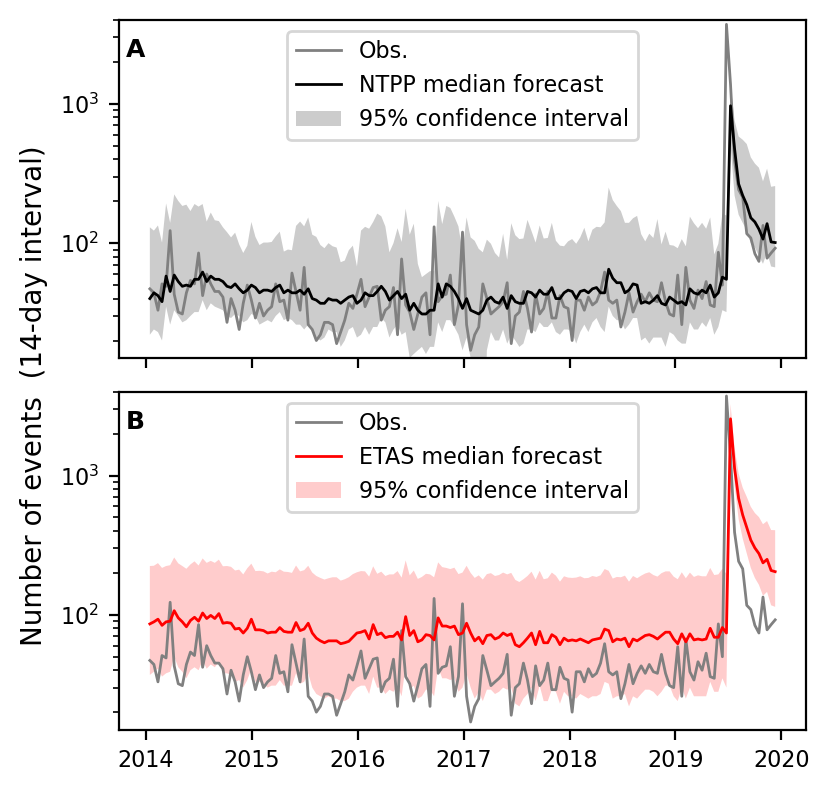

In [18]:
fig, ax = plt.subplots(2,1,figsize = (4,4), dpi=200,sharex=True,sharey=True)  

def plt_fc(df,c,label,AX):
    AX.plot(day2timestamp(df["t_start"]),df['n_obs'],c='grey',lw=1, label='Obs.')
    AX.plot(day2timestamp(df["t_start"]),df["N_50"], c=c,lw=1, label=f"{label} median forecast")
    AX.fill_between(
        day2timestamp(df["t_start"]), df["N_025"], df["N_975"],
        facecolor=c,
        alpha=0.2,
        label="95% confidence interval")
    AX.set_yscale('log')
    AX.set_ylim(15,4000)
    AX.legend(loc='upper center')

plt_fc(df_ntpp,'k','NTPP',ax[0])
plt_fc(df_etas,'r','ETAS',ax[1])
plt.tight_layout()

for n, ax in enumerate(ax):
    ax.text(0.01, 0.89, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=9, weight='bold')
    
fig.text(-0.02, 0.5, f'Number of events  ({duration}-day interval)', va='center', rotation='vertical',size=10);


**Fig S6: Comparison of 14-day forecasts during the test period for the SCEDC catalog (A-B).** Forecast and corresponding 95% confidence intervals are shown given the NTPP **(A)** and ETAS **(B)** models. Note that ETAS inherits the abnormally elevated rate of events that characterize the training set.